# Problem 1: Exploratory Data Analysis

In [207]:
from zipfile import ZipFile
import pandas as pd
myzip = ZipFile(r'C:\Users\Sissi Chen\Desktop\example\input\compustat.zip')     #load file from zip
f = myzip.open('compustat.csv')
df = pd.read_csv(f)
df = df.loc[:,['sic','datacqtr','cusip','cshoq','saleq','prccq']]
df.head()

,sic,datacqtr,cusip,cshoq,saleq,prccq
0,3089.0,1966Q1,000032102,0.219,NaN,NaN
1,3089.0,1966Q2,000032102,0.219,NaN,NaN
2,3089.0,1966Q3,000032102,0.219,NaN,NaN
3,3089.0,1966Q4,000032102,0.219,4.032,NaN
4,3089.0,1967Q1,000032102,0.277,NaN,NaN


In [41]:
df["mktcap"] = df.cshoq*df.prccq      #compute market cap
df["mktcap"].tail(5)

1811294          NaN
1811295    55.445500
1811296    25.895700
1811297    26.105953
1811298    20.051200
Name: mktcap, dtype: float64

### Find outliers  
We can use Tukey Method to check the outliers.  
i.e. get the interquartile range, and values below Q1-1.5IQR and above Q3+1.5IQR are considered as outliers

In [42]:
s_Q1 = df.saleq.quantile(.25)
s_Q3 = df.saleq.quantile(.75)
s_IQR = s_Q3 - s_Q1
s_outlier = df.saleq[(df.saleq < s_Q1-1.5*s_IQR) | (df.saleq > s_Q3+1.5*s_IQR)]    #Tukey method
m_Q1 = df.mktcap.quantile(.25)
m_Q3 = df.mktcap.quantile(.75)
m_IQR = m_Q3 - m_Q1
m_outlier = df.mktcap[(df.mktcap < m_Q1-1.5*m_IQR) | (df.mktcap > m_Q3+1.5*m_IQR)]
print(s_outlier.count(),m_outlier.count())
print(s_outlier.count()/df.saleq.count(),m_outlier.count()/df.mktcap.count())

234610 206869
0.1521662004370214 0.15403235834382584


Using Tukey Method, we can find some outliers, and they count for 15% of the total data for both indicators.   
This may due to the variability of sample，and indicate that the sample has very heavy tails.  

### Compute Statistics

In [43]:
s_mean = df.saleq.mean()
m_mean = df.mktcap.mean()
s_std = df.saleq.std()
m_std = df.mktcap.std()
s_nan = df.saleq.isnull().sum()
m_nan = df.mktcap.isnull().sum()
s_ratio = s_nan/(df.saleq.count()+s_nan)
m_ratio = m_nan/(df.mktcap.count()+m_nan)

In [44]:
s = pd.Series([s_mean,s_std,s_nan,s_ratio], index = ["mean","std","nan","nan ratio"])
m = pd.Series([m_mean,m_std,m_nan,m_ratio], index = ["mean","std","nan","nan ratio"])
s

mean            445.150664
std            2679.706576
nan          269498.000000
nan ratio         0.148787
dtype: float64

In [45]:
df_stats = pd.concat([s,m],axis = 1)
df_stats.columns = ['saleq','mktcap']      #put the statistics into a dataframe
df_stats

,saleq,mktcap
mean,445.150664,2057.473104
std,2679.706576,13202.197457
nan,269498.000000,468276.000000
nan ratio,0.148787,0.258530


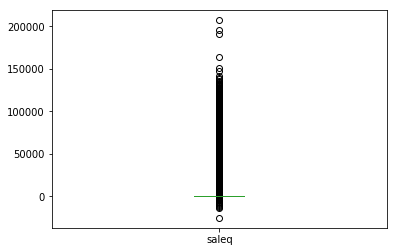

In [16]:
import matplotlib.pyplot as plt
df.saleq.plot.box()

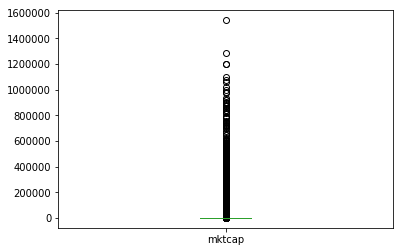

In [15]:
df.mktcap.plot.box()

Analyzing the above statistics and plots, we can see that for both indicators, there exists very large outliers that far exceeding the means, and many of them are hundreds of times larger than the means. Since the number of outliers are very large, we can tell that most of the outliers detected by Tukey Method come from sample variability, while only few are true outliers. The heavy tailsm also lead to very high stds.

# Problem 2: Compute Industry Concentration

Using the same data in question 1. Compute a panel data for HHI index for all industry, using a 2 digit SIC code.

Choose top 4 industry with the highest average HHI index, plot their time series pattern of HHI in a 2 by 2 figure.

In [208]:
df = df.dropna().reset_index()
df.head()

,index,sic,datacqtr,cusip,cshoq,saleq,prccq
0,18,3089.0,1970Q3,000032102,2.230,10.698,11.750
1,19,3089.0,1970Q4,000032102,2.446,10.919,10.000
2,20,3089.0,1971Q1,000032102,3.507,7.983,9.750
3,21,3089.0,1971Q2,000032102,3.518,9.885,8.250
4,22,3089.0,1971Q3,000032102,3.515,7.975,4.625


In [209]:
df.sic = df.sic.astype(str)        #change it to str type
df.sic = df.sic.str[:2]        #take the first two digits as sic industry code
df.sic.nunique()

70

In [210]:
df['saleq_groupsum'] = df.groupby(['sic','datacqtr']).saleq.transform('sum')     #total industry sales by quarter
df['mktshr'] = df.saleq/df.saleq_groupsum*100         #industry market share of each company in each quarter
df['mktshr_sqr'] = df.mktshr * df.mktshr
df['HHI'] = df.groupby(['sic','datacqtr']).mktshr_sqr.transform('sum')    #HHI for each industry in each quarter
df.head()

,index,sic,datacqtr,cusip,cshoq,saleq,prccq,saleq_groupsum,mktshr,mktshr_sqr,HHI
0,18,30,1970Q3,000032102,2.230,10.698,11.750,2636.569,0.405755,0.164637,1751.728141
1,19,30,1970Q4,000032102,2.446,10.919,10.000,3710.651,0.294261,0.086590,1247.507412
2,20,30,1971Q1,000032102,3.507,7.983,9.750,3144.142,0.253901,0.064466,1376.200579
3,21,30,1971Q2,000032102,3.518,9.885,8.250,4269.354,0.231534,0.053608,1229.647313
4,22,30,1971Q3,000032102,3.515,7.975,4.625,3471.214,0.229747,0.052784,1336.229848


In [213]:
df_HHI = df.drop_duplicates(['sic','datacqtr'])
df_HHI['HHI_average'] = df_HHI.groupby('sic').HHI.transform('mean')   #dataframe for all HHI
df_HHI_ave = df_HHI.loc[:,['sic','HHI_average']].drop_duplicates(['sic'])       #dataframe only for the mean
df_HHI_ave.count()

C:\Users\Sissi Chen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


sic            70
HHI_average    70
dtype: int64

In [203]:
df_HHI_ave.HHI_average = df_HHI_ave.HHI_average.astype('int')
df_HHI_ave.nlargest(4,'HHI_average')                 #the 4 industries with the largest HHI

,sic,HHI_average
1042134,86,10000
173723,84,9852
170635,90,9580
874782,81,9400


C:\Users\Sissi Chen\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


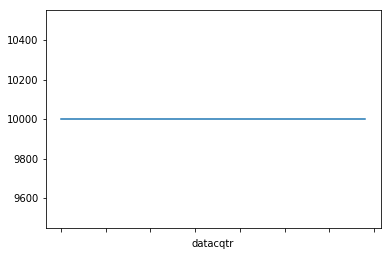

In [232]:
import matplotlib.pyplot as plt
df_HHI.sic = df_HHI.sic.astype('int')
df_HHI2 = df_HHI.loc[:,['sic','datacqtr','HHI']].set_index('datacqtr')
df_86 = df_HHI2.loc[df_HHI2.sic == 86]
df_86.HHI.plot()

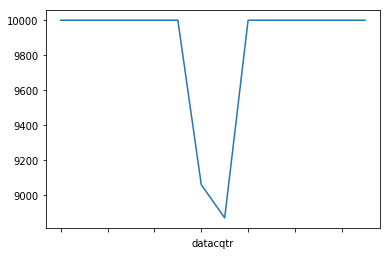

In [233]:
df_84 = df_HHI2.loc[df_HHI2.sic == 84]
df_84.HHI.plot()

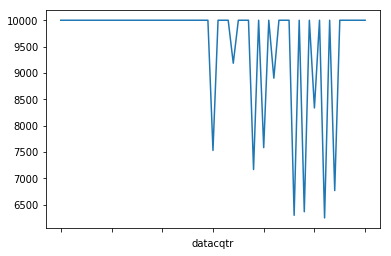

In [238]:
df_90 = df_HHI2.loc[df_HHI2.sic == 90]
df_90.HHI.plot()

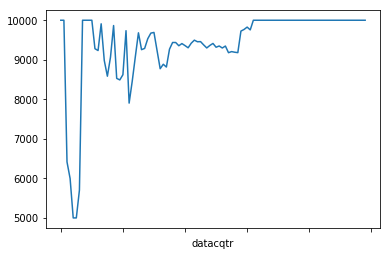

In [239]:
df_81 = df_HHI2.loc[df_HHI2.sic == 81]
df_81.HHI.plot()